# Assignment 1: Dynamic Time Warping

---

## Task 4) Isolated Word Recognition

Due to the relatively large sample number (e.g. 8kHz), performing [DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) on the raw audio signal is not advised (feel free to try!).
A better solution is to compute a set of features; here we will extract [mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) over windows of 25ms length, shifted by 10ms.
Recommended implementation is [librosa](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html).

### Data

Download Zohar Jackson's [free spoken digit dataset](https://github.com/Jakobovski/free-spoken-digit-dataset).
There's no need to clone, feel free to use a revision, like [v1.0.10](https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/tags/v1.0.10.tar.gz).
File naming convention is trivial (`{digitLabel}_{speakerName}_{index}.wav`); let's restrict to two speakers, eg. `jackson` and `george`.

### Dynamic Time Warping

[DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) is closely related to [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) and [Needleman-Wunsch algorithm](https://en.wikipedia.org/wiki/Needleman–Wunsch_algorithm).
The main rationale behind DTW is that the two sequences are can be aligned but their speed and exact realization may very.
In consequence, cost is not dependent on an edit operation but on a difference in observations.

---

### Preparation

In [3]:
%pip install librosa matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.0 kB/s eta 0:00:0000:0300:06m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.2 kB/s eta 0:00:00a 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 93.2 kB/s eta 0:00:00a 0:00:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 136.0 kB/s eta 0:00:00a 0:00:03
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import librosa as lr
from typing import List, Tuple, TypedDict
import os

In [2]:
### TODO: Read in files, compute MFCC, and organize
### Notice: You can restrict the number to a few files for each speaker-digit

class Audio(TypedDict):
    digitLabel: int
    speakerName: str
    index: int
    mfccs: List[Tuple[float]]

audios: List[Audio] = []

speakers = ["george", "jackson", "yweweler"]

### YOUR CODE HERE

for filename in os.listdir("./data/sound/"):
        filepath = os.path.join("./data/sound/", filename)
        label,speaker,index = filename.split('_')  # "jackson" oder "george"
        index = index.split('.')[0]  # remove ".wav"
        y, sr = lr.load(filepath, sr=None)
        mfccs = lr.feature.mfcc(y=y, sr=sr, n_mfcc=60)
        audios.append(Audio(digitLabel=int(label), speakerName=speaker, index=int(index), mfccs=mfccs))


### END YOUR CODE

/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(
/home/yannes/Documents/seqlrnass/.venv/lib64/python3.12/site-packages/

In [4]:
import matplotlib.pyplot as plt
import librosa.display

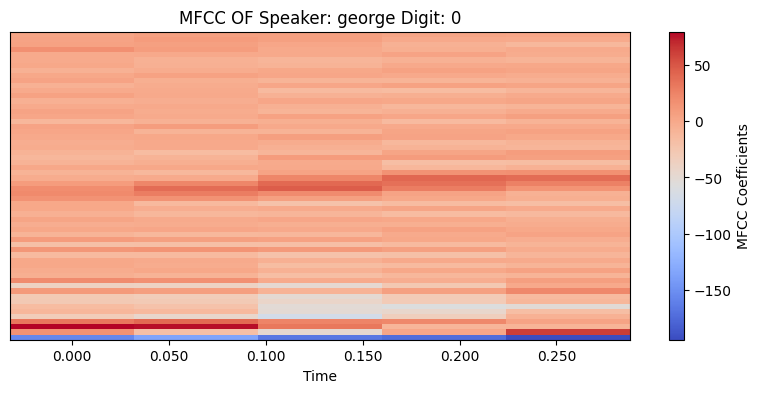

In [5]:

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(audios[0]["mfccs"], x_axis='time', sr=sr)
plt.colorbar(label='MFCC Coefficients')
plt.title('MFCC OF Speaker: {} Digit: {}'.format(audios[0]["speakerName"], audios[0]["digitLabel"]))

plt.show()

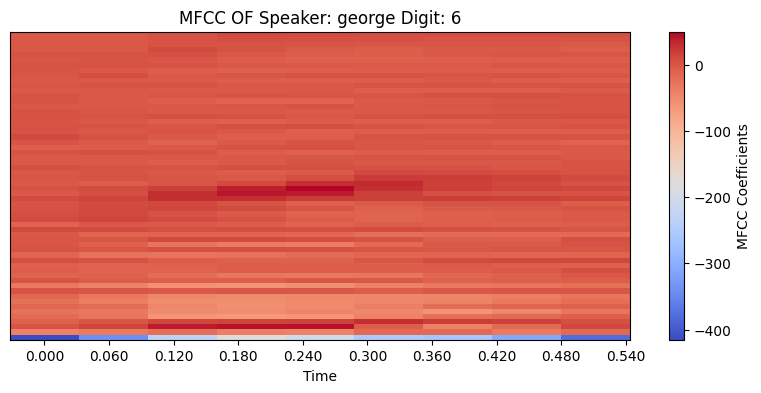

In [6]:
a= 600
# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(audios[a]["mfccs"], x_axis='time', sr=sr)
plt.colorbar(label='MFCC Coefficients')
plt.title('MFCC OF Speaker: {} Digit: {}'.format(audios[a]["speakerName"], audios[a]["digitLabel"]))

plt.show()

### Implement Dynamic Time Warping

In [7]:
import math
def dist(x: Tuple[float], y: Tuple[float]) -> float:
    """
    Compute the distance between two samples.

    Arguments:
    x: MFCCs of first sample.
    y: MFCCs of second sample.

    Returns the distance as float
    """
    ### YOUR CODE HERE
    x_arr = np.array(x)
    y_arr = np.array(y)
    max_len = max(len(x_arr), len(y_arr))
    
    x_padded = np.pad(x_arr, (0, max_len - len(x_arr)), mode='constant')
    y_padded = np.pad(y_arr, (0, max_len - len(y_arr)), mode='constant')
    
    return float(np.linalg.norm(x_padded - y_padded))

def dtw(x: list, y: list, dist_fn) -> float:
    """
    Compute the dynamic time warping score between two observations.
    
    Arguments:
    obs1: List of first observations.
    obs2: List of second observations.
    dist_fn: Similarity function to use.

    Returns the score as float.
    """
    ### YOUR CODE HERE
    D = np.full((len(x) + 1, len(y) + 1), np.inf, dtype=float)
    D[0, 0] = 0
    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            cost = dist_fn(x[i - 1], y[j - 1])
            D[i, j] = cost + min(D[i - 1, j],     
                                 D[i, j - 1],    
                                 D[i - 1, j - 1]) 
    return float(D[len(x), len(y)])

    return D[len(x)][len(y)]

    ### END YOUR CODE

### Experiment 1: DTW scores

For each speaker and digit, select one recording as an observation (obs1) and the others as tests (obs2). How do scores change across speakers and across digits?

In [8]:
### YOUR CODE HERE
sample1 = 1
sample2 = 500
dtw_score = dtw(audios[sample1]["mfccs"], audios[sample2]["mfccs"], dist)
print("DTW score between {} for {} and {}  for {} is: {}".format(audios[sample1]["speakerName"],audios[sample1]["digitLabel"], audios[sample2]["speakerName"], audios[sample2]["digitLabel"], dtw_score))

### END YOUR CODE

DTW score between george for 0 and george  for 5 is: 2855.3727741241455


In [9]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_dtw_matrix(audios: List[Audio]) -> None:
    n = len(audios)
    dtw_matrix = np.zeros((n, n))

    # Optional: sortiere nach digitLabel, speakerName, index
    audios_sorted = sorted(audios, key=lambda a: (a["digitLabel"], a["speakerName"], a["index"]))

    for i in range(n):
        for j in range(n):
            if i <= j:
                score = dtw(audios_sorted[i]["mfccs"], audios_sorted[j]["mfccs"], dist)
                dtw_matrix[i, j] = score
                dtw_matrix[j, i] = score  # Matrix ist symmetrisch

    # Plotten
    plt.figure(figsize=(10, 8))
    sns.heatmap(dtw_matrix, xticklabels=False, yticklabels=False, cmap="viridis", square=True)
    plt.title("DTW Distance Matrix")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.show()


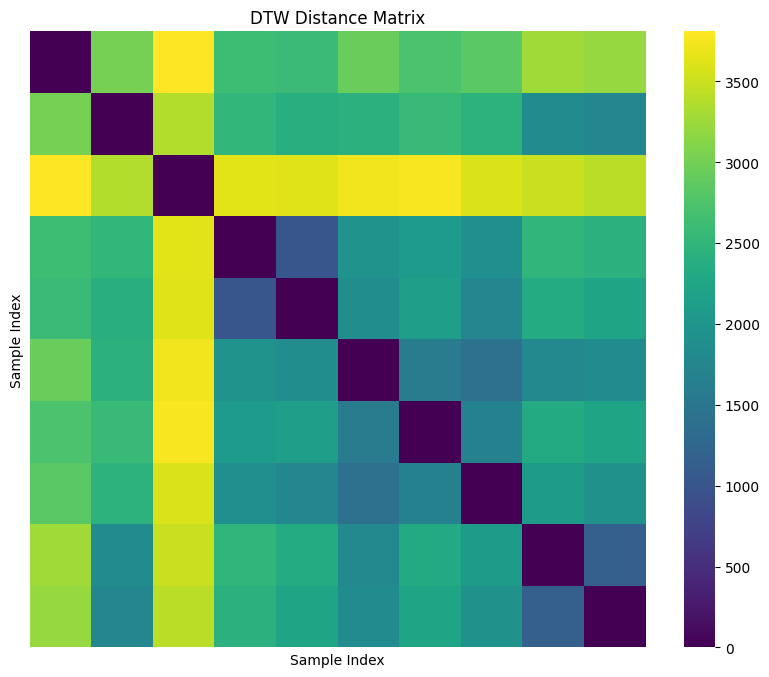

In [21]:
audioss=audios[0:10]
plot_dtw_matrix(audioss)

### Implement a DTW-based Isolated Word Recognizer

In [24]:
### TODO: Classify recording into digit label based on reference audio recordings

def recognize(obs: List[Tuple[float]], refs: List[Audio]) -> str:
    """
    Classify the input based on a reference list (train recordings).
    

    
    Returns classname where distance of observations is minumum.
    """
    ### YOUR CODE HERE
    
    minv = float("inf")
    class_name = "notfound"
    for ref in refs:
        dtw_s=  dtw(obs,ref["mfccs"],dist)
        if dtw_s<minv:
            minv=dtw_s
            class_name = ref["digitLabel"]
    return class_name
    ### END YOUR CODE

### Experiment 2: Speaker-Dependent IWR

Select training recordings from one speaker $S_i$ and disjoint test recordings from the same speaker $S_i$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

In [28]:
for i, val in enumerate(audios):
    print(i, " Speaker: ", val["speakerName"], "Digit: ", val["digitLabel"])

0  Speaker:  george Digit:  0
1  Speaker:  george Digit:  0
2  Speaker:  george Digit:  0
3  Speaker:  george Digit:  0
4  Speaker:  george Digit:  0
5  Speaker:  george Digit:  0
6  Speaker:  george Digit:  0
7  Speaker:  george Digit:  0
8  Speaker:  george Digit:  0
9  Speaker:  george Digit:  0
10  Speaker:  george Digit:  0
11  Speaker:  george Digit:  0
12  Speaker:  george Digit:  0
13  Speaker:  george Digit:  0
14  Speaker:  george Digit:  0
15  Speaker:  george Digit:  0
16  Speaker:  george Digit:  0
17  Speaker:  george Digit:  0
18  Speaker:  george Digit:  0
19  Speaker:  george Digit:  0
20  Speaker:  george Digit:  0
21  Speaker:  george Digit:  0
22  Speaker:  george Digit:  0
23  Speaker:  george Digit:  0
24  Speaker:  george Digit:  0
25  Speaker:  george Digit:  0
26  Speaker:  george Digit:  0
27  Speaker:  george Digit:  0
28  Speaker:  george Digit:  0
29  Speaker:  george Digit:  0
30  Speaker:  george Digit:  0
31  Speaker:  george Digit:  0
32  Speaker:  geor

In [34]:
### YOUR CODE HERE
import random
george_auds=[]
george_auds.append(audios[0])
george_auds.append(audios[100])
george_auds.append(audios[218])
george_auds.append(audios[339])
george_auds.append(audios[421])
george_auds.append(audios[530])
george_auds.append(audios[600])
george_auds.append(audios[700])
george_auds.append(audios[812])
george_auds.append(audios[917])
#selected=random.choice(audios)
selected= audios[300]
print(f'IS a:{selected["digitLabel"]} from {selected["speakerName"]}, regonized: {recognize(selected["mfccs"], george_auds)}')

### END YOUR CODE

IS a:3 from george, regonized: 6


### Experiment 3: Speaker-Independent IWR

Select training recordings from one speaker $S_i$ and test recordings from another speaker $S_j$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

In [ ]:
### YOUR CODE HERE



### END YOUR CODE

### Food for Thought

- What are inherent issues of this approach?
- How does this algorithm scale with a larger vocabulary, how can it be improved?
- How can you extend this idea to continuous speech, ie. ?